# SVM results and predictions

In [2]:
import glob

import numpy as np
import matplotlib.pyplot as plt 
from numpy import loadtxt
from sklearn.metrics import confusion_matrix, classification_report, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from pickle import load

# importing sys
import sys
  
# adding Folder_2 to the system path
sys.path.insert(0, '../../bioacoustics/3_classifier')
from model.svm_model import SVM_model
from data_preparation_svm import normalize

import predict

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd


In [4]:
import os

path = '/home/User/Desktop/file.txt'
  
# Split the path in 
# head and tail pair
os.path.split(path)[0]+'/'
  

'/home/User/Desktop/'

In [5]:
def read_preds(pred_file):
    preds = loadtxt(pred_file, dtype= str, delimiter='\n', unpack=False)
    print(len(pd.Series(preds)))
    return preds

def read_pred_probs(pred_file):
    pred_prob = pd.read_csv(pred_file)
    return pred_prob.apply(lambda x : x.max(), axis=1)

def read_y_test(y_test_file):
    y_test = pd.read_csv(y_test_file)
    print(y_test.shape)
    return y_test

def get_confusion_matrix(y_test,preds, file=None):
    labels=['background','chimpanze']
    cm = confusion_matrix(y_test,preds, normalize='true')

    print(cm)
    plt = plot_confusion_matrix(cm, ['background', 'chimpanze'], cmap='Blues', file=file)
    return plt
    
def get_classification_report(y_test, preds):
    cr = classification_report(y_test, preds , output_dict=True)
    return pd.DataFrame(cr).transpose()

def read_svm_results(path):
    svm_all_preds = read_preds(path + '/_predictions.txt')
    svm_all_y_test = read_y_test(path + '/_y_test.csv')
    return svm_all_preds, svm_all_y_test 

def read_file(file, dim):
    df = pd.read_csv(file)
    x = df.iloc[:, dim[0]:dim[1]]
    y = df['label_1']
    return x, y 

def filter_features(data, file, numfeat = 50):
    df = pd.read_csv(file)
    indices = list(df.sort_values(by=['feature_importances'], ascending=False).index[0:numfeat])
    return data[:, indices]

def read_files(file_path, dim, svm_dir):
    feature_file = svm_dir + 'feature_importances.csv'
    files = glob.glob(file_path)
    print(files)
    for i in range(len(files)):
        if i == 0:
            x, y = read_file(files[i], dim)
        else:
            temp_x, temp_y = read_file(files[i], dim)
            x = pd.concat([x, temp_x], sort=False)
            y = pd.concat([y, temp_y], sort=False)
    
    
    x = filter_features(x.to_numpy(), feature_file)
    return x, y

def run_svm(x_test, y_test, svm_dir):
    model_path = svm_dir + 'svm_model.sav'
    output_dir = svm_dir + 'predictions/'+folder+'/'
    s = SVM_model()
    s.predict_model(x_test, model_path, dl_model=False)
    s.save_results(y_test, output_dir)
    
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True, 
                          file=None):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    if file:
        plt.savefig(file) 
        
    plt.show()
    return plt
    

## Scenario 1: Sanctuary data only 

### Step 1: Plot test results

In [7]:
svm_dir = '../models/svm/sanctuary/'
preds, targets = read_svm_results(svm_dir)

18414
(18414, 1)


[[0.94066482 0.05933518]
 [0.05972649 0.94027351]]


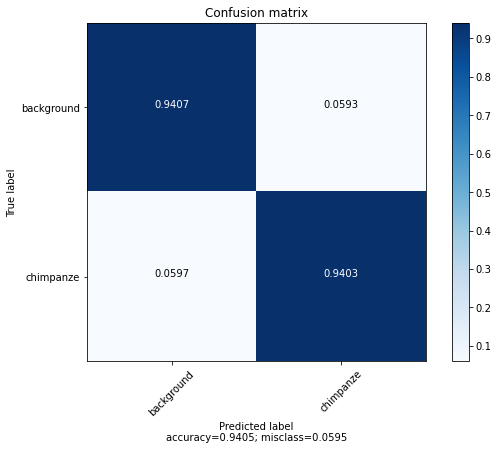

<module 'matplotlib.pyplot' from '/home/jelle/anaconda3/envs/animal-sounds/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [30]:
get_confusion_matrix(targets,preds)

In [31]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.984892,0.940665,0.962271,14831.000000
chimpanze,0.792892,0.940274,0.860317,3583.000000
accuracy,0.940589,0.940589,0.940589,0.940589
macro avg,0.888892,0.940469,0.911294,18414.000000
weighted avg,0.947533,0.940589,0.942432,18414.000000


### Step 2: Predict Using sanctuary

#### Apply svm

In [8]:
folders = ['A6', 'A21', 'A38']
for folder in folders:
    test_path = '../features/svm/sanaga/' + folder + '/*'

    x_test, y_test = read_files(test_path, [5, -1], svm_dir)
    x_test = normalize(x_test, svm_dir)

    run_svm(x_test, y_test, svm_dir)

['../features/svm/sanaga/A6/A6_background_24000.csv', '../features/svm/sanaga/A6/A6_chimpanze_24000.csv']


/home/jelle/anaconda3/envs/animal-sounds/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jelle/anaconda3/envs/animal-sounds/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jelle/anaconda3/envs/animal-sounds/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.24.1 when using version 1.1.1. This

prediction is done!
['../features/svm/sanaga/A21/A21_chimpanze_24000.csv', '../features/svm/sanaga/A21/A21_background_24000.csv']


/home/jelle/anaconda3/envs/animal-sounds/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jelle/anaconda3/envs/animal-sounds/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jelle/anaconda3/envs/animal-sounds/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.24.1 when using version 1.1.1. This

prediction is done!
['../features/svm/sanaga/A38/A38_background_24000.csv', '../features/svm/sanaga/A38/A38_chimpanze_24000.csv']


/home/jelle/anaconda3/envs/animal-sounds/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jelle/anaconda3/envs/animal-sounds/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jelle/anaconda3/envs/animal-sounds/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.24.1 when using version 1.1.1. This

prediction is done!


In [9]:
folder = 'A6'

preds, targets = read_svm_results(svm_dir + 'predictions/' + folder + '/')
targets[targets == 'chimp'] = 'chimpanze'
np.unique(targets)

112168
(112168, 1)


array(['background', 'chimpanze'], dtype=object)

[[0.81580324 0.18419676]
 [0.09657046 0.90342954]]


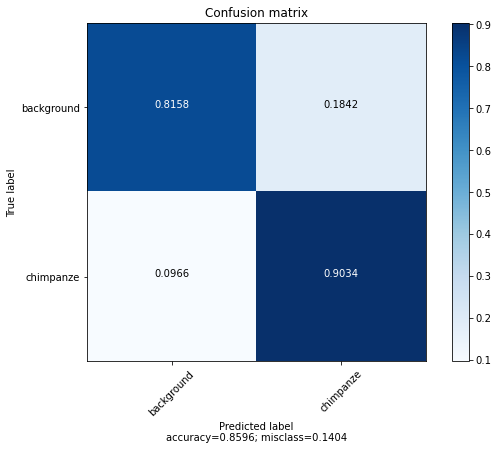

<module 'matplotlib.pyplot' from '/home/jelle/anaconda3/envs/animal-sounds/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [10]:
get_confusion_matrix(targets,preds)

In [11]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.925803,0.815803,0.867330,66885.000000
chimpanze,0.768552,0.903430,0.830550,45283.000000
accuracy,0.851179,0.851179,0.851179,0.851179
macro avg,0.847177,0.859616,0.848940,112168.000000
weighted avg,0.862320,0.851179,0.852481,112168.000000


In [10]:
folder = 'A21'

preds, targets = read_svm_results(svm_dir + 'predictions/' + folder + '/')
targets[targets == 'chimp'] = 'chimpanze'
np.unique(targets)

40610
(40610, 1)


array(['background', 'chimpanze'], dtype=object)

[[0.9796315  0.0203685 ]
 [0.57046811 0.42953189]]


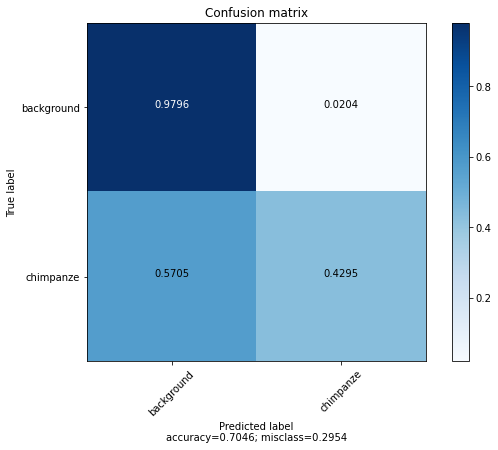

In [11]:
get_confusion_matrix(targets,preds)

In [12]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.727120,0.979632,0.834696,24695.000000
chimpanze,0.931462,0.429532,0.587942,15915.000000
accuracy,0.764048,0.764048,0.764048,0.764048
macro avg,0.829291,0.704582,0.711319,40610.000000
weighted avg,0.807201,0.764048,0.737994,40610.000000


In [13]:
folder = 'A38'

preds, targets = read_svm_results(svm_dir + 'predictions/' + folder + '/')
targets[targets == 'chimp'] = 'chimpanze'
np.unique(targets)

101988
(101988, 1)


array(['background', 'chimpanze'], dtype=object)

[[0.92878346 0.07121654]
 [0.28133439 0.71866561]]


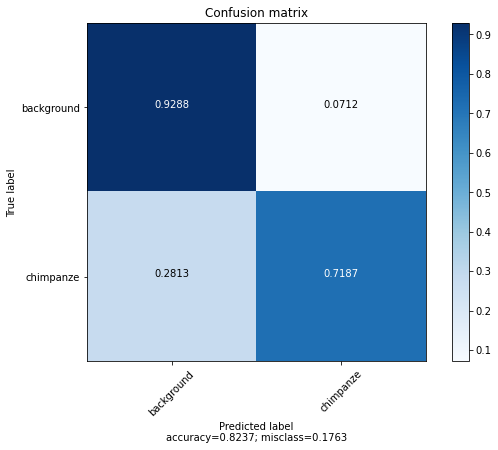

In [14]:
get_confusion_matrix(targets,preds)

In [15]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.909668,0.928783,0.919126,76808.000000
chimpanze,0.767886,0.718666,0.742461,25180.000000
accuracy,0.876907,0.876907,0.876907,0.876907
macro avg,0.838777,0.823725,0.830794,101988.000000
weighted avg,0.874663,0.876907,0.875509,101988.000000


In [15]:
### Now the above recorders combined
folders = ['A6', 'A21', 'A38']

targets = pd.DataFrame()
preds = []

for folder in folders:
    preds_tmp, targets_tmp = read_svm_results(svm_dir + 'predictions/' + folder + '/')
    targets_tmp[targets_tmp == 'chimp'] = 'chimpanze'
    targets = targets.append(targets_tmp, ignore_index=True)
    preds.extend(preds_tmp)


112168
(112168, 1)
40610
(40610, 1)
101988
(101988, 1)


[[0.89136399 0.10863601]
 [0.23774572 0.76225428]]


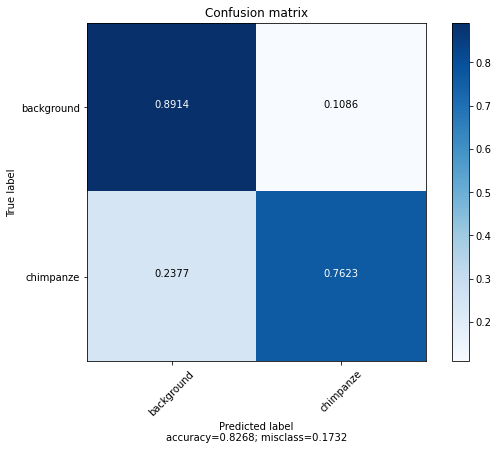

In [16]:
get_confusion_matrix(targets,preds)

In [7]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.879647,0.891364,0.885467,168388.00000
chimpanze,0.782576,0.762254,0.772281,86378.00000
accuracy,0.847590,0.847590,0.847590,0.84759
macro avg,0.831111,0.826809,0.828874,254766.00000
weighted avg,0.846735,0.847590,0.847091,254766.00000


## Scenario 2: Synthetic data only

### Step 1: Plot Test results (synthetic data test set)

In [9]:
svm_dir = '../models/svm/synthetic/'
preds, targets = read_svm_results(svm_dir)

33179
(33179, 1)


[[17709  1720]
 [ 2896 10854]]


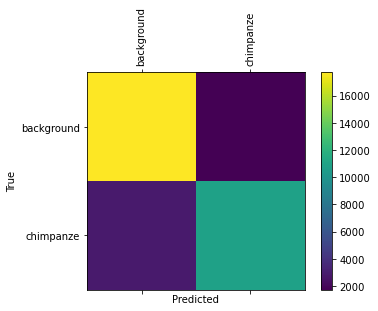

In [10]:
get_confusion_matrix(targets,preds)

In [11]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.859452,0.911473,0.884698,19429.000000
chimpanze,0.863210,0.789382,0.824647,13750.000000
accuracy,0.860876,0.860876,0.860876,0.860876
macro avg,0.861331,0.850427,0.854672,33179.000000
weighted avg,0.861009,0.860876,0.859812,33179.000000


### Step 2: Predict Using synthetic data

#### Apply svm

In [12]:
folders = ['A6', 'A21', 'A38']
for folder in folders:
    test_path = '../features/svm/sanaga/' + folder + '/*'

    x_test, y_test = read_files(test_path, [5, -1], svm_dir)
    x_test = normalize(x_test, svm_dir)

    run_svm(x_test, y_test, svm_dir)

['../features/svm/sanaga/A6/A6_background_24000.csv', '../features/svm/sanaga/A6/A6_chimpanze_24000.csv']
prediction is done!
['../features/svm/sanaga/A21/A21_chimpanze_24000.csv', '../features/svm/sanaga/A21/A21_background_24000.csv']
prediction is done!
['../features/svm/sanaga/A38/A38_background_24000.csv', '../features/svm/sanaga/A38/A38_chimpanze_24000.csv']
prediction is done!


In [13]:
folder = 'A6'

preds, targets = read_svm_results(svm_dir + 'predictions/' + folder + '/')
targets[targets == 'chimp'] = 'chimpanze'
np.unique(targets)

112168
(112168, 1)


array(['background', 'chimpanze'], dtype=object)

[[22867 44018]
 [ 2041 43242]]


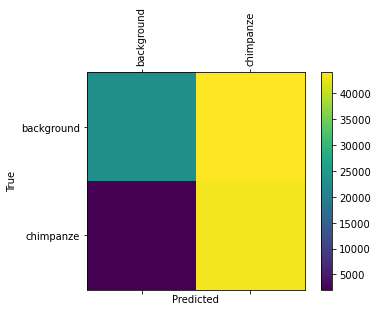

In [14]:
get_confusion_matrix(targets,preds)

In [15]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.918058,0.341885,0.498230,66885.000000
chimpanze,0.495554,0.954928,0.652498,45283.000000
accuracy,0.589375,0.589375,0.589375,0.589375
macro avg,0.706806,0.648407,0.575364,112168.000000
weighted avg,0.747490,0.589375,0.560509,112168.000000


In [16]:
folder = 'A21'

preds, targets = read_svm_results(svm_dir + 'predictions/' + folder + '/')
targets[targets == 'chimp'] = 'chimpanze'
np.unique(targets)

40610
(40610, 1)


array(['background', 'chimpanze'], dtype=object)

[[ 4742 19953]
 [ 1307 14608]]


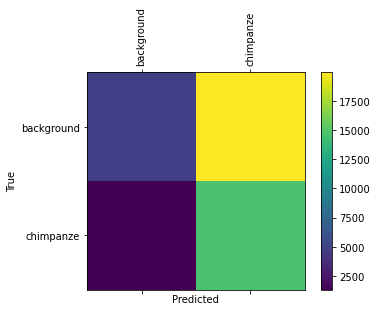

In [17]:
get_confusion_matrix(targets,preds)

In [18]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.783931,0.192023,0.308483,24695.000000
chimpanze,0.422673,0.917876,0.578810,15915.000000
accuracy,0.476484,0.476484,0.476484,0.476484
macro avg,0.603302,0.554949,0.443646,40610.000000
weighted avg,0.642355,0.476484,0.414424,40610.000000


In [19]:
folder = 'A38'

preds, targets = read_svm_results(svm_dir + 'predictions/' + folder + '/')
targets[targets == 'chimp'] = 'chimpanze'
np.unique(targets)

101988
(101988, 1)


array(['background', 'chimpanze'], dtype=object)

[[21538 55270]
 [ 2580 22600]]


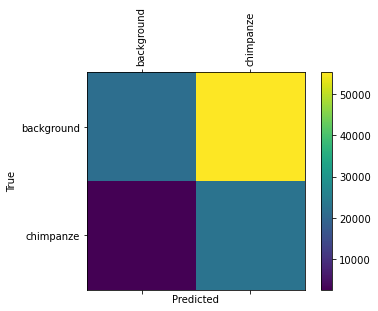

In [20]:
get_confusion_matrix(targets,preds)

In [21]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.893026,0.280413,0.426808,76808.000000
chimpanze,0.290227,0.897538,0.438622,25180.000000
accuracy,0.432776,0.432776,0.432776,0.432776
macro avg,0.591627,0.588976,0.432715,101988.000000
weighted avg,0.744200,0.432776,0.429725,101988.000000


In [22]:
### Now the above recorders combined
folders = ['A6', 'A21', 'A38']

targets = pd.DataFrame()
preds = []

for folder in folders:
    preds_tmp, targets_tmp = read_svm_results(svm_dir + 'predictions/' + folder + '/')
    targets_tmp[targets_tmp == 'chimp'] = 'chimpanze'
    targets = targets.append(targets_tmp, ignore_index=True)
    preds.extend(preds_tmp)


112168
(112168, 1)
40610
(40610, 1)
101988
(101988, 1)


[[ 49147 119241]
 [  5928  80450]]


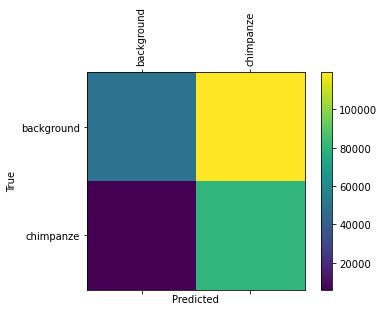

In [23]:
get_confusion_matrix(targets,preds)

In [24]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.892365,0.291868,0.439867,168388.00000
chimpanze,0.402872,0.931371,0.562452,86378.00000
accuracy,0.508690,0.508690,0.508690,0.50869
macro avg,0.647619,0.611620,0.501159,254766.00000
weighted avg,0.726403,0.508690,0.481429,254766.00000


## Scenario 3: All data (sanctuary + synthetic)

### Step 1: Plot Test results (synthetic + sanctuary data test set)

In [17]:
svm_dir = '../models/svm/all/'
preds, targets = read_svm_results(svm_dir)

51593
(51593, 1)


[[0.93721541 0.06278459]
 [0.18634974 0.81365026]]


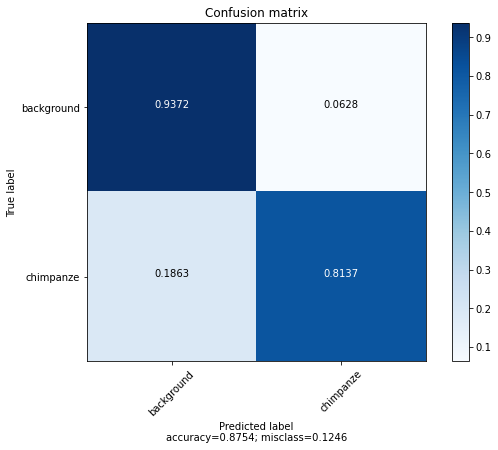

In [18]:
get_confusion_matrix(targets,preds)

In [7]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.908600,0.937215,0.922686,34260.000000
chimpanze,0.867663,0.813650,0.839789,17333.000000
accuracy,0.895703,0.895703,0.895703,0.895703
macro avg,0.888131,0.875433,0.881237,51593.000000
weighted avg,0.894847,0.895703,0.894836,51593.000000


### Step 2: Predict Using svm trained on all data (sanctuary + synthetic)

#### Apply svm

In [8]:
folders = ['A6', 'A21', 'A38']
for folder in folders:
    test_path = '../features/svm/sanaga/' + folder + '/*'

    x_test, y_test = read_files(test_path, [5, -1], svm_dir)
    x_test = normalize(x_test, svm_dir)

    run_svm(x_test, y_test, svm_dir)

['../features/svm/sanaga/A6/A6_background_24000.csv', '../features/svm/sanaga/A6/A6_chimpanze_24000.csv']
prediction is done!
['../features/svm/sanaga/A21/A21_chimpanze_24000.csv', '../features/svm/sanaga/A21/A21_background_24000.csv']
prediction is done!
['../features/svm/sanaga/A38/A38_background_24000.csv', '../features/svm/sanaga/A38/A38_chimpanze_24000.csv']
prediction is done!


In [22]:
folder = 'A6'

preds, targets = read_svm_results(svm_dir + 'predictions/' + folder + '/')
targets[targets == 'chimp'] = 'chimpanze'
np.unique(targets)

112168
(112168, 1)


array(['background', 'chimpanze'], dtype=object)

[[0.85147641 0.14852359]
 [0.10734713 0.89265287]]


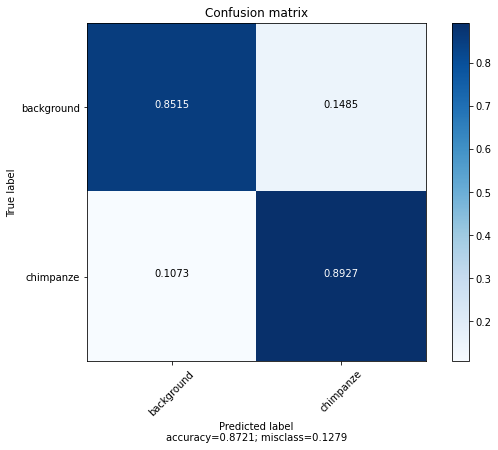

<module 'matplotlib.pyplot' from '/home/jelle/anaconda3/envs/animal-sounds/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [28]:
get_confusion_matrix(targets,preds, file='../results/A6_matrix.png')


In [12]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.921358,0.851476,0.885040,66885.0000
chimpanze,0.802725,0.892653,0.845304,45283.0000
accuracy,0.868100,0.868100,0.868100,0.8681
macro avg,0.862041,0.872065,0.865172,112168.0000
weighted avg,0.873465,0.868100,0.868998,112168.0000


In [32]:
folder = 'A21'

preds, targets = read_svm_results(svm_dir + 'predictions/' + folder + '/')
targets[targets == 'chimp'] = 'chimpanze'
np.unique(targets)

40610
(40610, 1)


array(['background', 'chimpanze'], dtype=object)

[[24113   582]
 [ 7919  7996]]


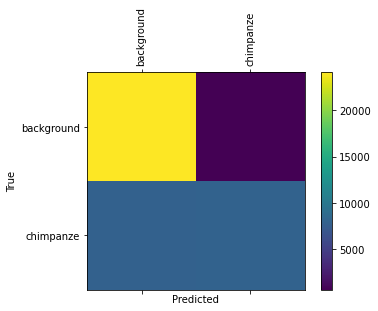

In [33]:
get_confusion_matrix(targets,preds)

In [34]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.752778,0.976432,0.850142,24695.000000
chimpanze,0.932152,0.502419,0.652921,15915.000000
accuracy,0.790667,0.790667,0.790667,0.790667
macro avg,0.842465,0.739426,0.751532,40610.000000
weighted avg,0.823075,0.790667,0.772851,40610.000000


In [35]:
folder = 'A38'

preds, targets = read_svm_results(svm_dir + 'predictions/' + folder + '/')
targets[targets == 'chimp'] = 'chimpanze'
np.unique(targets)

101988
(101988, 1)


array(['background', 'chimpanze'], dtype=object)

[[71778  5030]
 [ 6974 18206]]


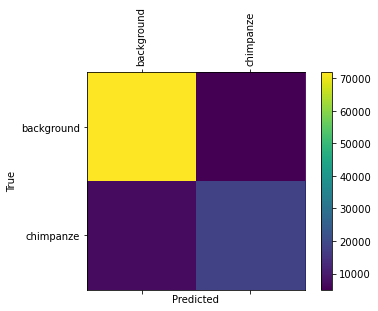

In [36]:
get_confusion_matrix(targets,preds)

In [37]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.911444,0.934512,0.922834,76808.0000
chimpanze,0.783526,0.723034,0.752065,25180.0000
accuracy,0.882300,0.882300,0.882300,0.8823
macro avg,0.847485,0.828773,0.837450,101988.0000
weighted avg,0.879862,0.882300,0.880672,101988.0000


In [19]:
### Now the above recorders combined
folders = ['A6', 'A21', 'A38']

targets = pd.DataFrame()
preds = []

for folder in folders:
    preds_tmp, targets_tmp = read_svm_results(svm_dir + 'predictions/' + folder + '/')
    targets_tmp[targets_tmp == 'chimp'] = 'chimpanze'
    targets = targets.append(targets_tmp, ignore_index=True)
    preds.extend(preds_tmp)


112168
(112168, 1)
40610
(40610, 1)
101988
(101988, 1)


[[0.90767751 0.09232249]
 [0.22869249 0.77130751]]


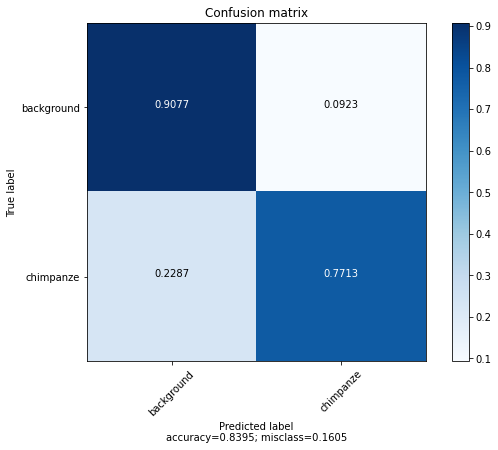

In [20]:
get_confusion_matrix(targets,preds)

In [21]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.885548,0.907678,0.896476,168388.000000
chimpanze,0.810807,0.771308,0.790564,86378.000000
accuracy,0.861441,0.861441,0.861441,0.861441
macro avg,0.848177,0.839493,0.843520,254766.000000
weighted avg,0.860207,0.861441,0.860567,254766.000000
